In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-20 05:53:30--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: 'names.txt'

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-05-20 05:53:31 (6.51 MB/s) - 'names.txt' saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# number of words
len(words)

32033

In [5]:
# building the vocab of chars and mapping to/from ints
char = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(char)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [6]:
# building the dataset
context_length = 3 # number of characters we take as input to output the next one

def build_dataset(words: str, visualize: bool = False) -> (torch.int64, torch.int64):
    X, Y = [], []
    
    for w in words:
        
        context = [0]*context_length
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            if (visualize):
                print (''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [7]:
import random

In [8]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((27, 10), generator = g) # seems to be the embedding matrix, with size (vocab_size, embedding_size)
W1 = torch.randn((30, 200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters) # number of params

11897

In [11]:
for p in parameters:
    p.requires_grad = True

In [12]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [13]:
lri = []
lossi = []
stepi = []

In [14]:
for i in range(200_000):
    
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # takes random 32 inputs from the Xtr
    
    # forward pass
    # Xtr[ix] takes the ix^th index, and considers the input values, three context at that index
    
    # Thus, here, ix belongs to range(0, num_char)
    # Xtr.shape = [num_char, context_length] and outputs are in the range (vocab_length)
    # C.shape = [vocab_length, embedding size] and outputs are embeddings, which seem to be an updated version on one_hot
    # embedding.shape = [batch_size, context_length, embedding_size] and outputs are embeddings!
    emb = C[Xtr[ix]] # (32, 3, 10)
    # thus here, W1 must be [embedding_size, output_neurons]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) for hidden_layer h
    # thus here, W2 must be [input_neurons, output_neurons]
    logits = h @ W2 + b2 # (32, 27) [batch_size, vocab_length]
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    # print(loss.item())

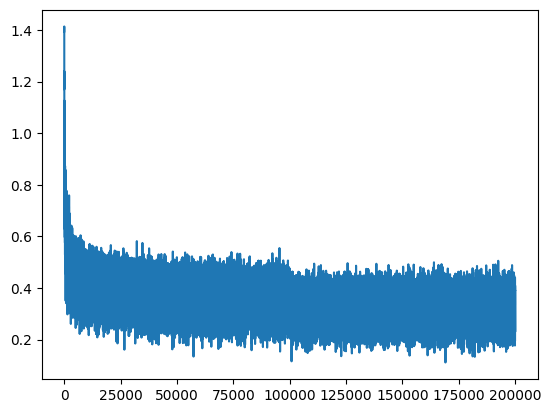

In [15]:
plt.plot(stepi, lossi)

In [16]:
# training loss
emb = C[Xtr] # (182625, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (182625, 100)
logits = h @ W2 + b2 # (182625, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1216, grad_fn=<NllLossBackward0>)

In [17]:
# validation loss
emb = C[Xdev] # (dev_size, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (dev_size, 100)
logits = h @ W2 + b2 # (dev_size, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1637, grad_fn=<NllLossBackward0>)

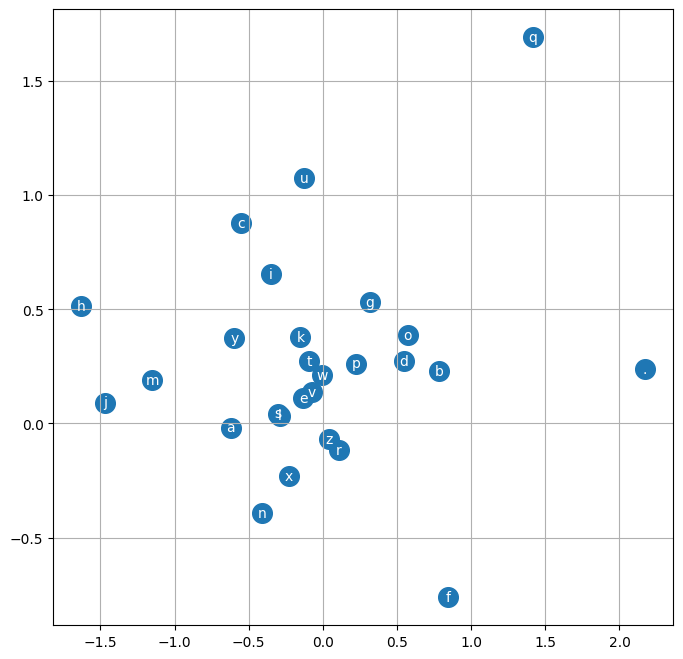

In [18]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [19]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

montaimyah.
see.
mad.
ryah.
rethan.
endrae.
cadee.
daelin.
shy.
jen.
edennestanar.
kayzion.
kamin.
shub.
rishiriel.
kindreth.
konnie.
cayu.
zayven.
kympremeha.
